In [1]:
import numpy as np
from copy import deepcopy as deep_copy
import time
import pandas as pd
import csv
from pgmpy.estimators import BicScore
from pgmpy.estimators import BayesianEstimator
from pgmpy.models import BayesianModel
import networkx as nx

In [2]:
def classic_pso(nvar, ncal, type, function, chi, w):

    class Problem:

        def __init__(self, nvar, ncal, type, function, chi, w):
            #
            # particle parameters
            self.c1 = 1.4
            self.c2 = 1.4
            self.chi = chi
            self.w = w
            #
            # problem parameters
            self.dimension = nvar
            self.n_cal = ncal
            self.lower_bound = -0.49
            self.upper_bound = 2.49
            self.type_PSO = type         # (Global / Local)
            self.function = function     # (Sphere / Rastrigin)
            #
            # population parameters
            self.nao_dag = []
            self.g_best_position = []
            self.g_best_value = np.inf   # default
            if np.sqrt(self.n_cal) > 30:
                self.swarm_size = 30
            else:
                self.swarm_size = int(np.sqrt(self.n_cal))
            self.n_iter = self.n_cal//self.swarm_size
            if self.type_PSO == 'Global':
                self.neighbours = self.swarm_size
            elif self.type_PSO == 'Local':
                self.neighbours = 2
            #
            # Read Cancer problem data ---------------------------------------------------------------------------------
            if self.function == 'Cancer':
                with open('cancer100k.csv') as csv_file:
                    csv_reader = csv.reader(csv_file, delimiter=',')
                    aux = 0
                    data = []
                    data1 = [[] for i in range(5)]
                    for row in csv_reader:
                        data.append(row)
                        for i in range(len(row)):
                            data1[i].append(row[i])
                        aux = aux + 1
                        if aux == 50001:
                            break
                    data = {}
                for i in range(len(data1)):
                    data[data1[i][0]] = [data1[i][j] for j in range(1, len(data1[i]))]
                data = pd.DataFrame(data)
                #print("Data: ")
                #print(data)  # Dada retieved from file
                self.data = data
                self.bic_score=BicScore(data)
                self.nodes = ['Pollution', 'Smoker', 'Cancer', 'Xray', 'Dyspnoea']
                if self.dimension != 10:
                    print("Warning: nvar should be equal to 10")
            #
            # Read Asia Problem data -----------------------------------------------------------------------------------
            elif self.function == 'Cancer':
                with open('ASIA10k.csv') as csv_file:
                    csv_reader = csv.reader(csv_file, delimiter=',')
                    aux = 0
                    data = []
                    data1 = [[] for i in range(5)]
                    for row in csv_reader:
                        data.append(row)
                        for i in range(len(row)):
                            data1[i].append(row[i])
                        aux = aux + 1
                        if aux == 50001:
                            break
                    data = {}
                for i in range(len(data1)):
                    data[data1[i][0]] = [data1[i][j] for j in range(1, len(data1[i]))]
                data = pd.DataFrame(data)
                #print("Data: ")
                #print(data)  # Dada retieved from file
                self.data = data
                self.bic_score=BicScore(data)
                self.nodes = ['asia', 'tub', 'smoke', 'lung', 'bronc', 'either', 'xray', 'dysp']
                if self.dimension != 32:
                    print("Warning: nvar should be equal to 32")
                
        def vetor_Rede(self, solucao, nodes):
            G_aux = BayesianModel()
            # G_aux.add_nodes_from(nodes)
            k = 0
            aux = 1
            for i in range(1, len(nodes)):
                for j in range(aux):
                    if solucao[k] == 1:
                        if nodes[i] in G_aux.nodes() and nodes[j] in G_aux.nodes() and nx.has_path(G_aux,
                                                                                                   nodes[j],
                                                                                                   nodes[i]):
                            return False
                        else:
                            G_aux.add_edge(nodes[i], nodes[j])
                    elif solucao[k] == 2:
                        if nodes[i] in G_aux.nodes() and nodes[j] in G_aux.nodes() and nx.has_path(G_aux,
                                                                                                   nodes[i],
                                                                                                   nodes[j]):
                            return False
                        else:
                            G_aux.add_edge(nodes[j], nodes[i])
                    k = k + 1
                aux = aux + 1
            for i in nodes:
                if i not in G_aux.nodes():
                    return False
            return G_aux

        def cost_function(self, x):
            #
            # ============= Cancer Bayes Model =========================================================================
            if self.function == 'Cancer':
                G = self.vetor_Rede(solucao=x, nodes=self.nodes)
                return abs(BicScore(self.data).score(G))
            #
            # ============= Asia Bayes Model ===========================================================================
            if self.function == 'Asia':
                G = self.vetor_Rede(solucao=x, nodes=self.nodes)
                return abs(BicScore(self.data).score(G))
            # ==========================================================================================================
            

    class Particle(Problem):

        def __init__(self):
            Problem.__init__(self, nvar, ncal, type, function, chi, w)
            flag = False
            while flag == False:
                aux_2 = np.random.rand(self.dimension) * \
                    (self.upper_bound - self.lower_bound) + self.lower_bound
                aux = []
                for i in aux_2:
                    aux.append(int(i.round()))
                if aux not in self.nao_dag:
                #if flag2 == False:
                    G=self.vetor_Rede(aux, self.nodes)
                    if G:
                        self.position = aux
                        self.fitness = Problem.cost_function(self, x=self.position)
                        flag = True
                        #fitness.append(abs(bic_score.score(G)))
                    else:
                        self.nao_dag.append(aux)     

        def calc_fitness(self):
            self.fitness = Problem.cost_function(self, x=list(self.position.round()))
            return self.fitness

        def move(self, velocity):
            self.position = self.position + velocity
            for i in range(self.dimension):
                flag = False
                while flag is False:    # make the particle bounce
                    if self.position[i] > self.upper_bound:
                        self.position[i] = self.upper_bound - (self.position[i] - self.upper_bound)
                    if self.position[i] < self.lower_bound:
                        self.position[i] = self.lower_bound - (self.position[i] - self.lower_bound)
                    if self.lower_bound < self.position[i] < self.upper_bound:
                        flag = True
            return self.position

        def update_velocity(self, velocity, p_best_position, g_best_position):
            r1 = np.random.rand(self.dimension)
            r2 = np.random.rand(self.dimension)
            cognitive = self.c1 * r1 * (p_best_position - self.position)
            social = self.c2 * r2 * (g_best_position - self.position)
            velocity = self.chi * (self.w * velocity + cognitive + social)
            return velocity

    class PSO(Problem):

        def __init__(self):
            Problem.__init__(self, nvar, ncal, type, function, chi, w)
            self.swarm = np.zeros([self.swarm_size, self.dimension])
            self.fitness = np.zeros(self.swarm_size) + np.inf
            self.velocity = np.zeros([self.swarm_size, self.dimension])
            self.personal_best = np.zeros(self.swarm_size) + np.inf
            self.personal_best_pos = np.zeros([self.swarm_size, self.dimension])
            if self.type_PSO == 'Global':
                self.global_best = np.inf
                self.global_best_pos = np.zeros(self.dimension)
            elif self.type_PSO == 'Local':
                self.global_best = np.zeros(self.swarm_size) + np.inf
                self.global_best_pos = np.zeros([self.swarm_size, self.dimension])
            #
            # initialize swarm
            for i in range(self.swarm_size):
                part = Particle()
                self.swarm[i, :] = part.position
                self.fitness[i] = part.fitness
                self.personal_best_pos[i, :] = self.swarm[i, :]
                self.personal_best[i] = self.fitness[i]
            self.global_best, self.global_best_pos = \
                self.update_best(g_best_value=self.global_best, g_best_position=self.global_best_pos)
            self.optimize()

        def optimize(self):
            for i in range(self.n_iter):
                print('iteration = ' + str(i))
                # Update position of the particles
                for k in range(self.swarm_size):
                    part = Particle()
                    part.position = self.swarm[k, :]
                    if self.type_PSO == 'Global':
                        self.velocity[k, :] = part.update_velocity(velocity=self.velocity[k, :],
                                                                   p_best_position=self.personal_best_pos[k, :],
                                                                   g_best_position=self.global_best_pos)
                    elif self.type_PSO == 'Local':
                        self.velocity[k, :] = part.update_velocity(velocity=self.velocity[k, :],
                                                                   p_best_position=self.personal_best_pos[k, :],
                                                                   g_best_position=self.global_best_pos[k, :])
                    part.position = part.move(self.velocity[k, :])
                    #
                    # nao_dag restriction
                    aux = list(part.position.round())
                    if aux not in self.nao_dag:
                        G=self.vetor_Rede(aux, self.nodes)
                        if G:
                            self.swarm[k, :] = part.position
                            self.fitness[k] = part.calc_fitness()
                            flag = True
                        else:
                            self.nao_dag.append(aux)     
                            self.swarm[k, :] = part.position
                    if self.fitness[k] < self.personal_best[k]:
                        self.personal_best[k] = self.fitness[k]
                        self.personal_best_pos[k, :] = self.swarm[k, :]
                self.global_best, self.global_best_pos = \
                    self.update_best(g_best_value=self.global_best, g_best_position=self.global_best_pos)
            return self.global_best, self.global_best_pos

        def update_best(self, g_best_value, g_best_position):
            if self.type_PSO == 'Global':
                for i in range(self.swarm_size):
                    if self.fitness[i] < g_best_value:
                        g_best_value = deep_copy(self.fitness[i])
                        g_best_position = deep_copy(self.swarm[i, :])
            elif self.type_PSO == 'Local':
                aux_g_best_value = deep_copy(g_best_value)
                aux_1 = -1
                aux_2 = 1
                for i in range(self.swarm_size):
                    if aux_2 >= self.swarm_size:
                        aux_2 = 0
                    vector = [aux_g_best_value[aux_1], self.fitness[i], aux_g_best_value[aux_2]]
                    g_best_value[i] = deep_copy(np.min(vector))
                    if np.argmin(vector) == 0:
                        g_best_position[i, :] = deep_copy(g_best_position[aux_1, :])
                    elif np.argmin(vector) == 1:
                        g_best_position[i, :] = deep_copy(self.swarm[i, :])
                    elif np.argmin(vector) == 2:
                        g_best_position[i, :] = deep_copy(g_best_position[aux_2, :])
                    aux_1 += 1
                    aux_2 += 1
            return g_best_value, g_best_position

    prob = Problem(nvar, ncal, type, function, chi, w)

    p = PSO()

    print('========== Parameters of PSO ===========')
    print('dimension = ' + str(prob.dimension))
    print('n_cal = ' + str(prob.n_cal))
    print('pop size = ' + str(prob.swarm_size))
    print('chi = ' + str(prob.chi))
    print('weight inertia = ' + str(prob.w))
    print('type_PSO = ' + prob.type_PSO)
    print('function = ' + str(prob.function))
    print('================ BEST ==================')
    if prob.type_PSO == 'Global':
        print('global best =' + str(p.global_best))
        print('and its position = ' + str(p.global_best_pos))
        gbest = p.global_best
        gbest_position = p.global_best_pos
    elif prob.type_PSO == 'Local':
        print('global best =' + str(np.min(p.global_best)))
        print('and its position = ' + str(p.global_best_pos[np.argmin(p.global_best)]))
        gbest = np.min(p.global_best)
        gbest_position = p.global_best_pos[np.argmin(p.global_best)]
    #
    # check model
    G=p.vetor_Rede(list(p.global_best_pos.round()), p.nodes)
    nx.draw(G, with_labels=True)
    G.fit(p.data, estimator=BayesianEstimator, prior_type="BDeu")
    G.check_model()
    
    return gbest, gbest_position


Observação n°: 0
iteration = 0
iteration = 1
iteration = 2
iteration = 3
iteration = 4
iteration = 5
iteration = 6
iteration = 7
iteration = 8
iteration = 9
iteration = 10
iteration = 11
iteration = 12
iteration = 13
iteration = 14
iteration = 15
iteration = 16
iteration = 17
iteration = 18
iteration = 19
iteration = 20
iteration = 21
iteration = 22
iteration = 23
iteration = 24
iteration = 25
iteration = 26
iteration = 27
iteration = 28
iteration = 29
iteration = 30
iteration = 31
iteration = 32
iteration = 33
iteration = 34
iteration = 35
iteration = 36
iteration = 37
iteration = 38
iteration = 39
========== Parameters of PSO ===========
dimension = 10
n_cal = 1200
pop size = 30
chi = 0.9
weight inertia = 0.9
type_PSO = Global
function = Cancer
================ BEST ==================
global best =105353.89542887188
and its position = [ 1.          0.84367357  1.4009708  -0.10189755  0.48483663  1.20814441
 -0.24567403  0.18492238  1.52710737  0.12358401]
Observação n°: 1
iteration =

iteration = 24
iteration = 25
iteration = 26
iteration = 27
iteration = 28
iteration = 29
iteration = 30
iteration = 31
iteration = 32
iteration = 33
iteration = 34
iteration = 35
iteration = 36
iteration = 37
iteration = 38
iteration = 39
========== Parameters of PSO ===========
dimension = 10
n_cal = 1200
pop size = 30
chi = 0.9
weight inertia = 0.9
type_PSO = Global
function = Cancer
================ BEST ==================
global best =105348.63938927921
and its position = [-0.30704069  1.79220407  1.74677782  0.45888108 -0.24800922  1.65550903
  0.01400579 -0.32084623  1.57613159 -0.47801313]
Observação n°: 9
iteration = 0
iteration = 1
iteration = 2
iteration = 3
iteration = 4
iteration = 5
iteration = 6
iteration = 7
iteration = 8
iteration = 9
iteration = 10
iteration = 11
iteration = 12
iteration = 13
iteration = 14
iteration = 15
iteration = 16
iteration = 17
iteration = 18
iteration = 19
iteration = 20
iteration = 21
iteration = 22
iteration = 23
iteration = 24
iteration = 2

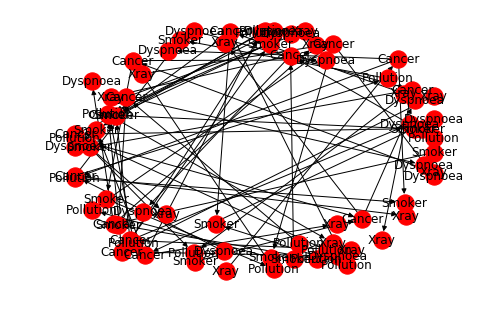

In [3]:
amostras = 15
bic = []
var = []
for o in range(amostras):
    print('Observação n°: ' + str(o))
    f, x = classic_pso(nvar=10, ncal=1200, type='Global', function='Cancer', chi=0.9, w=0.9)
    bic.append(f)
    var.append(x)

In [6]:
with open('.PSO_cancer.csv', "w", newline='') as csv_file:
    writer = csv.writer(csv_file, delimiter=',')
    for line in bic:
        writer.writerow(line)

Error: iterable expected, not numpy.float64

In [8]:
bic

[105353.89542887188,
 105353.89542887188,
 105348.63938927921,
 105353.89542887188,
 105353.89542887188,
 105353.89542887188,
 105348.63938927921,
 105353.89542887188,
 105348.63938927921,
 105353.89542887188,
 105353.89542887188,
 105353.89542887188,
 105348.63938927921,
 105348.63938927921,
 105348.63938927921]